# Lake Erie Harmful Algal Bloom Analysis
## Project Blue Nexus — Notebook 02

**Author:** Ryan Jones | Brook Park, Ohio  
**Date:** February 2026  
**Tools:** Python · xarray · cartopy · scipy · NOAA ERDDAP  

---

### Objective

Quantify the relationship between Sea Surface Temperature and harmful algal bloom intensity in Lake Erie across multiple years. Notebook 01 established that warm western-basin SST spatially overlaps with elevated chlorophyll-a. This notebook asks the harder questions: *How strong is the correlation? Does chlorophyll lag temperature? Are blooms getting worse?*

### Scientific Context

Lake Erie's western basin receives massive nutrient loads (dissolved phosphorus) from the Maumee River watershed — agricultural runoff from Ohio, Indiana, and Michigan farmland. When warm surface temperatures combine with abundant nutrients, toxic *Microcystis aeruginosa* blooms explode. The 2011 and 2014 blooms were among the worst recorded, with the 2014 event shutting down Toledo's drinking water supply.

Temperature alone doesn't cause blooms — nutrients are the fuel and warmth is the catalyst. But SST is the variable we can monitor daily from satellites, making it a potential early-warning indicator.

### Building on Notebook 01

This analysis uses the same ERDDAP data infrastructure and extends it:

| Notebook 01 (SST Analysis) | Notebook 02 (HAB Analysis) |
|---|---|
| Single-day chlorophyll snapshot | Full-summer chlorophyll time series |
| Spatial correlation (one date) | Temporal correlation (lag analysis) |
| 5-year SST comparison | 5-year SST + chlorophyll comparison |
| Descriptive statistics | Predictive relationship |

---


In [1]:
# Core scientific libraries
import time
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats, signal
from datetime import datetime
import requests
import warnings
warnings.filterwarnings('ignore')

# Ensure output directories exist
os.makedirs('../data', exist_ok=True)
os.makedirs('output', exist_ok=True)

print("All libraries loaded successfully")
print(f"xarray: {xr.__version__}")
print(f"scipy: {__import__('scipy').__version__}")


All libraries loaded successfully
xarray: 2025.6.1
scipy: 1.15.3


## Step 1: Data Discovery — Chlorophyll-a Coverage Assessment

Before designing the analysis, we need to understand what chlorophyll data is available. Key questions: What years are covered? What's the temporal resolution? Are there gaps (cloud cover, winter darkness)?

We'll query the GLERL ERDDAP metadata endpoint to get the full picture, then fetch a summer-long time series to understand the data's characteristics.


In [2]:
# Lake Erie bounding box (shared with Notebook 01)
LAKE_ERIE = {
    'lat_min': 41.3, 'lat_max': 42.9,
    'lon_min': -83.5, 'lon_max': -78.8
}

# Western Basin mask boundary (where HABs concentrate)
WEST_BASIN_LON = -82.5  # West of this longitude

# ============================================================
# ERDDAP Dataset Discovery
# ============================================================
SST_DATASET = "GLSEA_GCS"
CHL_DATASET = "LE_CHL_VIIRS_SQ"
BASE_URL = "https://apps.glerl.noaa.gov/erddap"

print("=" * 60)
print("ERDDAP Dataset Discovery")
print("=" * 60)

for dataset_id, label in [(SST_DATASET, "SST (GLSEA)"), (CHL_DATASET, "Chlorophyll (VIIRS)")]:
    info_url = f"{BASE_URL}/info/{dataset_id}/index.json"
    print(f"\n--- {label}: {dataset_id} ---")
    
    try:
        resp = requests.get(info_url, timeout=20)
        if resp.status_code == 200:
            rows = resp.json()['table']['rows']
            
            # Extract key metadata
            for row in rows:
                attr_name = row[2] if len(row) > 2 else ""
                attr_value = row[4] if len(row) > 4 else ""
                
                if attr_name in ['time_coverage_start', 'time_coverage_end', 
                                  'geospatial_lat_min', 'geospatial_lat_max',
                                  'geospatial_lon_min', 'geospatial_lon_max',
                                  'title']:
                    print(f"  {attr_name}: {attr_value}")
            
            # Get variable names
            vars_found = [row[1] for row in rows if row[0] == 'variable' 
                          and row[1] not in ['time', 'lat', 'lon', 'latitude', 'longitude']]
            print(f"  Variables: {vars_found}")
        else:
            print(f"  ERROR: Status {resp.status_code}")
    except Exception as e:
        print(f"  ERROR: {e}")

print("\n" + "=" * 60)
print("Discovery complete. Check time ranges above to plan fetch strategy.")


ERDDAP Dataset Discovery

--- SST (GLSEA): GLSEA_GCS ---
  geospatial_lat_max: 50.6059751976539
  geospatial_lat_min: 38.8749871947297
  geospatial_lon_max: -75.8816402880531
  geospatial_lon_min: -92.4199507342304
  time_coverage_end: 2023-12-31T12:00:00Z
  time_coverage_start: 1995-01-01T12:00:00Z
  title: Sea Surface Temperature (SST) from Great Lakes Surface Environmental Analysis (GLSEA), Geodetic coordinate system (LAT, LON), 1995-2023
  Variables: ['sst']

--- Chlorophyll (VIIRS): LE_CHL_VIIRS_SQ ---
  geospatial_lat_max: 43.0179972728271
  geospatial_lat_min: 41.2690208353805
  geospatial_lon_max: -78.4429490894234
  geospatial_lon_min: -83.6574899492178
  time_coverage_end: 2026-01-30T18:14:08Z
  time_coverage_start: 2018-05-28T17:42:17Z
  title: Color Producing Agent (CPA) Chlorophyll, VIIRS, Lake Erie (2018-present)
  Variables: ['Chlorophyll']

Discovery complete. Check time ranges above to plan fetch strategy.


## Step 2: Full-Summer Chlorophyll-a Time Series (2023)

Unlike SST (which has one clean composite per day), VIIRS chlorophyll has multiple satellite overpasses per day and significant data gaps from cloud cover. We need to:

1. Fetch the full June–September 2023 chlorophyll record
2. Compute daily spatial averages (handling NaN from clouds)
3. Assess data completeness — how many usable days do we get?

This will tell us whether we have enough temporal resolution for meaningful time-series analysis.


In [3]:
# ============================================================
# Fetch full summer 2023 chlorophyll-a data (month by month)
# Same caching strategy as Notebook 01
# ============================================================

chl_months = [
    ("2023-06-01", "2023-06-30", "june"),
    ("2023-07-01", "2023-07-31", "july"),
    ("2023-08-01", "2023-08-31", "august"),
    ("2023-09-01", "2023-09-30", "september"),
]

chl_datasets = []

for start, end, month_name in chl_months:
    filename = f"../data/lake_erie_chl_2023_{month_name}.nc"
    
    # Check cache
    if os.path.exists(filename) and os.path.getsize(filename) > 1000:
        print(f"Chl {month_name.title()} 2023: Loading from cache...", end=" ")
        try:
            ds_month = xr.open_dataset(filename, engine="netcdf4")
            chl_datasets.append(ds_month)
            print(f"OK ({len(ds_month.time)} time slices)")
            continue
        except Exception as e:
            print(f"Cache corrupted ({e}), re-downloading.")
    
    # Fetch from ERDDAP
    url = (
        f"{BASE_URL}/griddap/{CHL_DATASET}.nc"
        f"?Chlorophyll"
        f"[({start}T00:00:00Z):1:({end}T23:59:59Z)]"
        f"[({LAKE_ERIE['lat_min']}):1:({LAKE_ERIE['lat_max']})]"
        f"[({LAKE_ERIE['lon_min']}):1:({LAKE_ERIE['lon_max']})]"
    )
    
    print(f"Fetching Chl {month_name.title()} 2023...", end="", flush=True)
    
    for attempt in range(1, 4):
        try:
            resp = requests.get(url, timeout=300)
            
            if resp.status_code == 200 and b'<!DOCTYPE' not in resp.content[:100]:
                with open(filename, "wb") as f:
                    f.write(resp.content)
                ds_month = xr.open_dataset(filename, engine="netcdf4")
                chl_datasets.append(ds_month)
                print(f" OK ({len(ds_month.time)} time slices, {len(resp.content)/1024:.0f} KB)")
                time.sleep(15)  # Server cooldown
                break
            elif resp.status_code == 404:
                print(f" 404 Not Found")
                print(f"  URL: {url[:120]}...")
                print(f"  Server: {resp.text[:200]}")
                break
            else:
                print(f" Status {resp.status_code}", end="")
                if attempt < 3:
                    print(", retrying...", end="", flush=True)
                    time.sleep(10 * attempt)
        except Exception as e:
            print(f" Error: {e}", end="")
            if attempt < 3:
                time.sleep(10)

# Combine
if chl_datasets:
    ds_chl = xr.concat(chl_datasets, dim='time')
    ds_chl = ds_chl.sortby('time')  # Ensure chronological order
    print(f"\nChlorophyll dataset: {len(ds_chl.time)} time slices")
    print(f"  Date range: {str(ds_chl.time.values[0])[:10]} to {str(ds_chl.time.values[-1])[:10]}")
    print(f"  Grid: {ds_chl.Chlorophyll.shape}")
else:
    print("\nERROR: No chlorophyll data loaded!")


Chl June 2023: Loading from cache... OK (53 time slices)
Chl July 2023: Loading from cache... OK (50 time slices)
Chl August 2023: Loading from cache... OK (61 time slices)
Chl September 2023: Loading from cache... OK (50 time slices)

Chlorophyll dataset: 214 time slices
  Date range: 2023-05-31 to 2023-09-30
  Grid: (214, 248, 727)


### Data Completeness Assessment

VIIRS is an optical sensor — it can't see through clouds. On cloudy days, chlorophyll values will be NaN. We need to know what fraction of the summer has usable data, because this determines whether daily, weekly, or monthly averaging is the right approach for time-series analysis.


In [4]:
# ============================================================
# Assess data completeness and create daily composites
# ============================================================

# For each time slice, compute the fraction of non-NaN pixels over the lake
total_pixels = ds_chl.Chlorophyll.isel(time=0).size
valid_fraction = []
times = pd.to_datetime(ds_chl.time.values)

for t in range(len(ds_chl.time)):
    slice_data = ds_chl.Chlorophyll.isel(time=t)
    valid = float(slice_data.count()) / total_pixels
    valid_fraction.append(valid)

valid_df = pd.DataFrame({'time': times, 'valid_fraction': valid_fraction})
valid_df['date'] = valid_df['time'].dt.date

print(f"Total satellite overpasses: {len(valid_df)}")
print(f"Unique dates: {valid_df['date'].nunique()}")
print(f"Mean coverage per overpass: {np.mean(valid_fraction)*100:.1f}%")
print(f"Overpasses with >10% coverage: {sum(v > 0.10 for v in valid_fraction)}")
print(f"Overpasses with >30% coverage: {sum(v > 0.30 for v in valid_fraction)}")

# Create DAILY composites by averaging all overpasses per day
# This reduces cloud gaps — multiple passes per day fill each other in
daily_chl = ds_chl.Chlorophyll.groupby('time.date').mean(dim='time')
print(f"\nDaily composites: {len(daily_chl.date)} days")

# Compute lake-wide daily mean (spatial average, ignoring NaN)
chl_daily_mean = daily_chl.mean(dim=['latitude', 'longitude'])
chl_valid_days = int((~np.isnan(chl_daily_mean.values)).sum())
print(f"Days with valid lake-wide mean: {chl_valid_days} of {len(daily_chl.date)}")

# Also compute western basin daily mean
west_mask = ds_chl.longitude < WEST_BASIN_LON
chl_west_daily = daily_chl.where(west_mask).mean(dim=['latitude', 'longitude'])


Total satellite overpasses: 214
Unique dates: 118
Mean coverage per overpass: 9.8%
Overpasses with >10% coverage: 82
Overpasses with >30% coverage: 7

Daily composites: 118 days
Days with valid lake-wide mean: 118 of 118


## Step 3: SST and Chlorophyll-a — Paired Time Series

Now we load the matching SST data from Notebook 01's cache and plot both variables on the same timeline. This is the foundation for everything that follows — seeing both curves together reveals whether chlorophyll tracks, lags, or is independent of temperature.

We focus on the **western basin** specifically, since that's where both thermal extremes and bloom activity concentrate.


In [5]:
# ============================================================
# Load matching SST data (from Notebook 01 cache)
# ============================================================
sst_months = [
    ("june", "2023-06-01", "2023-06-30"),
    ("july", "2023-07-01", "2023-07-31"),
    ("august", "2023-08-01", "2023-08-31"),
    ("september", "2023-09-01", "2023-09-30"),
]

sst_datasets = []
for month_name, start, end in sst_months:
    filename = f"../data/lake_erie_sst_2023_{month_name}.nc"
    if os.path.exists(filename):
        ds = xr.open_dataset(filename, engine="netcdf4")
        sst_datasets.append(ds)
        print(f"SST {month_name.title()}: {len(ds.time)} days")
    else:
        print(f"SST {month_name.title()}: NOT FOUND at {filename}")

ds_sst = xr.concat(sst_datasets, dim='time')
print(f"\nSST dataset: {len(ds_sst.time)} days, {str(ds_sst.time.values[0])[:10]} to {str(ds_sst.time.values[-1])[:10]}")

# Compute western basin SST daily mean
west_mask_sst = ds_sst.longitude < WEST_BASIN_LON
sst_west_daily = ds_sst.sst.where(west_mask_sst).mean(dim=['latitude', 'longitude'])
sst_dates = pd.to_datetime(ds_sst.time.values)

print(f"Western basin SST range: {float(sst_west_daily.min()):.1f}°C to {float(sst_west_daily.max()):.1f}°C")


SST June: 30 days
SST July: 31 days
SST August: 31 days
SST September: 30 days

SST dataset: 122 days, 2023-06-01 to 2023-09-30
Western basin SST range: 18.4°C to 25.0°C


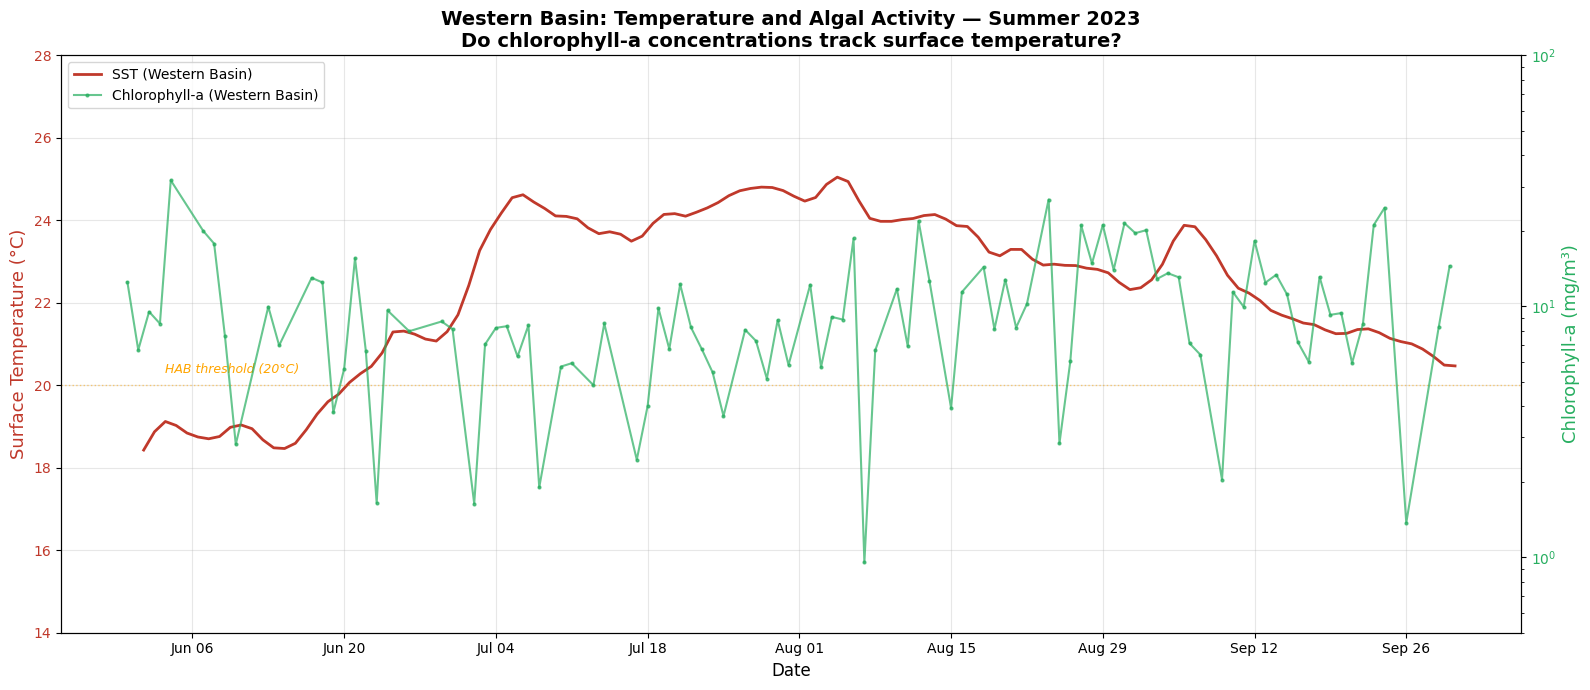

Western Basin Chlorophyll-a range: 0.95 to 31.76 mg/m³
Valid chlorophyll days: 99 of 118


In [6]:
# ============================================================
# Dual-axis time series: SST + Chlorophyll (Western Basin)
# ============================================================
fig, ax1 = plt.subplots(figsize=(16, 7))

# SST on left axis
color_sst = '#C0392B'
ax1.plot(sst_dates, sst_west_daily, color=color_sst, linewidth=2, label='SST (Western Basin)')
ax1.set_ylabel('Surface Temperature (°C)', fontsize=13, color=color_sst)
ax1.tick_params(axis='y', labelcolor=color_sst)
ax1.set_ylim(14, 28)

# HAB threshold
ax1.axhline(y=20, color='orange', linestyle=':', alpha=0.5, linewidth=1)
ax1.text(sst_dates[2], 20.3, 'HAB threshold (20°C)', fontsize=9, color='orange', style='italic')

# Chlorophyll on right axis
ax2 = ax1.twinx()
color_chl = '#27AE60'

# Convert daily_chl dates to datetime for plotting
chl_dates = pd.to_datetime(chl_daily_mean.date.values)
chl_values = chl_daily_mean.values
# Also get western basin values
chl_west_values = chl_west_daily.values

# Filter out NaN days for cleaner plotting
valid_mask = ~np.isnan(chl_west_values)
ax2.plot(chl_dates[valid_mask], chl_west_values[valid_mask], 
         color=color_chl, linewidth=1.5, alpha=0.7, marker='.', markersize=4,
         label='Chlorophyll-a (Western Basin)')
ax2.set_ylabel('Chlorophyll-a (mg/m³)', fontsize=13, color=color_chl)
ax2.tick_params(axis='y', labelcolor=color_chl)
ax2.set_yscale('log')
ax2.set_ylim(0.5, 100)

# Formatting
ax1.set_xlabel('Date', fontsize=12)
ax1.set_title('Western Basin: Temperature and Algal Activity — Summer 2023\n'
              'Do chlorophyll-a concentrations track surface temperature?',
              fontsize=14, fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/hab_sst_chl_timeseries_2023.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Western Basin Chlorophyll-a range: {np.nanmin(chl_west_values):.2f} to {np.nanmax(chl_west_values):.2f} mg/m³")
print(f"Valid chlorophyll days: {valid_mask.sum()} of {len(chl_west_values)}")


## Step 4: SST–Chlorophyll Correlation Analysis

With both time series in hand, we can quantify the statistical relationship. We'll compute:

1. **Pearson correlation** — linear relationship strength between daily SST and chlorophyll
2. **Time-lagged cross-correlation** — does chlorophyll peak *after* SST peaks? If so, by how many days?
3. **Scatter plot with regression** — visualize the relationship and compute R²

The lag analysis is scientifically important: if blooms consistently follow temperature peaks by 1–2 weeks, SST becomes a **predictive** indicator, not just a coincident one.


In [7]:
# ============================================================
# Align SST and Chlorophyll on matching dates
# ============================================================

# Create DataFrames for easy merging
sst_df = pd.DataFrame({
    'date': sst_dates.date,
    'sst_west': sst_west_daily.values
})

chl_df = pd.DataFrame({
    'date': pd.to_datetime(chl_daily_mean.date.values).date,
    'chl_lake': chl_daily_mean.values,
    'chl_west': chl_west_daily.values
})

# Merge on date — only keep days where both SST and Chl have valid data
merged = pd.merge(sst_df, chl_df, on='date', how='inner')
merged = merged.dropna(subset=['sst_west', 'chl_west'])
merged['date'] = pd.to_datetime(merged['date'])

print(f"Paired observations: {len(merged)} days")
print(f"Date range: {merged['date'].min().strftime('%Y-%m-%d')} to {merged['date'].max().strftime('%Y-%m-%d')}")

# ============================================================
# 1. Pearson Correlation (same-day)
# ============================================================
r, p_value = stats.pearsonr(merged['sst_west'], merged['chl_west'])
print(f"\nSame-day Pearson r = {r:.3f}  (p = {p_value:.4f})")
if p_value < 0.01:
    print("  → Statistically significant (p < 0.01)")

# Also try with log-transformed chlorophyll (often more normal)
r_log, p_log = stats.pearsonr(merged['sst_west'], np.log10(merged['chl_west']))
print(f"Pearson r (log₁₀ Chl) = {r_log:.3f}  (p = {p_log:.4f})")

# ============================================================
# 2. Time-Lagged Cross-Correlation
# ============================================================
# Interpolate both series to fill small gaps, then cross-correlate
sst_interp = merged.set_index('date')['sst_west'].resample('D').interpolate(limit=3)
chl_interp = merged.set_index('date')['chl_west'].resample('D').interpolate(limit=3)

# Align
aligned = pd.DataFrame({'sst': sst_interp, 'chl': chl_interp}).dropna()

max_lag = 30  # Check up to 30 days
lag_correlations = []

for lag in range(-max_lag, max_lag + 1):
    if lag >= 0:
        sst_shifted = aligned['sst'].iloc[:len(aligned)-lag].values
        chl_shifted = aligned['chl'].iloc[lag:].values
    else:
        sst_shifted = aligned['sst'].iloc[-lag:].values
        chl_shifted = aligned['chl'].iloc[:len(aligned)+lag].values
    
    if len(sst_shifted) > 10:
        r_lag, _ = stats.pearsonr(sst_shifted, chl_shifted)
        lag_correlations.append((lag, r_lag))

lag_df = pd.DataFrame(lag_correlations, columns=['lag_days', 'correlation'])
peak_lag = lag_df.loc[lag_df['correlation'].idxmax()]
print(f"\nPeak correlation: r = {peak_lag['correlation']:.3f} at lag = {int(peak_lag['lag_days'])} days")
if peak_lag['lag_days'] > 0:
    print(f"  → Chlorophyll peaks {int(peak_lag['lag_days'])} days AFTER SST peak")
elif peak_lag['lag_days'] < 0:
    print(f"  → Chlorophyll peaks {int(abs(peak_lag['lag_days']))} days BEFORE SST peak")
else:
    print(f"  → No lag detected — peaks are concurrent")


Paired observations: 98 days
Date range: 2023-06-01 to 2023-09-30

Same-day Pearson r = -0.191  (p = 0.0597)
Pearson r (log₁₀ Chl) = -0.148  (p = 0.1467)

Peak correlation: r = 0.471 at lag = 30 days
  → Chlorophyll peaks 30 days AFTER SST peak


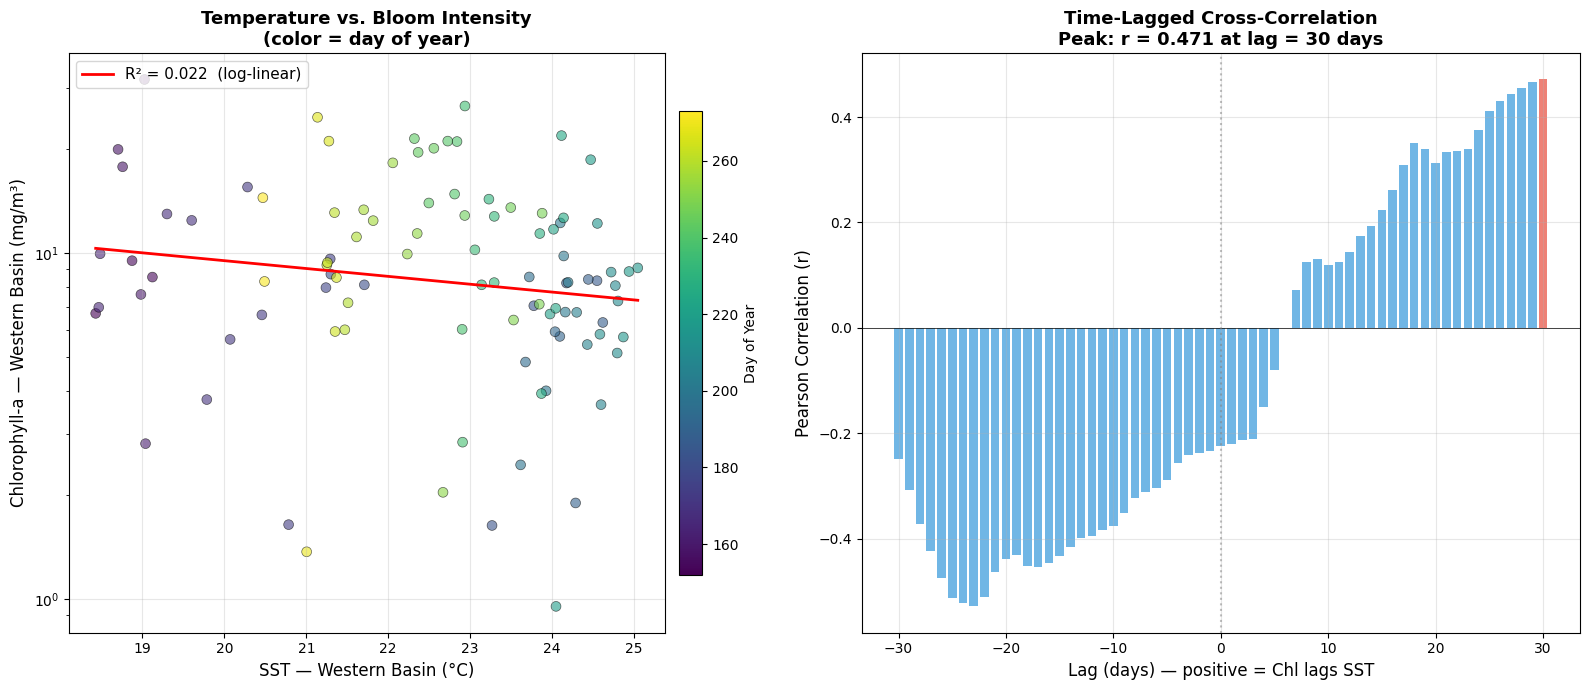

In [8]:
# ============================================================
# Visualization: Scatter + Lag Correlation
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Scatter plot with regression
ax1.scatter(merged['sst_west'], merged['chl_west'], 
            alpha=0.6, c=merged['date'].dt.dayofyear, cmap='viridis', 
            edgecolors='black', linewidth=0.5, s=50)
ax1.set_yscale('log')

# Add regression line (on log-transformed data)
slope, intercept, r_val, p_val, std_err = stats.linregress(
    merged['sst_west'], np.log10(merged['chl_west']))
x_fit = np.linspace(merged['sst_west'].min(), merged['sst_west'].max(), 100)
y_fit = 10**(slope * x_fit + intercept)
ax1.plot(x_fit, y_fit, 'r-', linewidth=2, 
         label=f'R² = {r_val**2:.3f}  (log-linear)')

ax1.set_xlabel('SST — Western Basin (°C)', fontsize=12)
ax1.set_ylabel('Chlorophyll-a — Western Basin (mg/m³)', fontsize=12)
ax1.set_title('Temperature vs. Bloom Intensity\n(color = day of year)', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# Colorbar for day-of-year
sm = plt.cm.ScalarMappable(cmap='viridis', 
     norm=plt.Normalize(merged['date'].dt.dayofyear.min(), merged['date'].dt.dayofyear.max()))
cbar = plt.colorbar(sm, ax=ax1, shrink=0.8, pad=0.02)
cbar.set_label('Day of Year', fontsize=10)

# Right: Lag cross-correlation
ax2.bar(lag_df['lag_days'], lag_df['correlation'], 
        color=np.where(lag_df['lag_days'] == peak_lag['lag_days'], '#E74C3C', '#3498DB'),
        alpha=0.7)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Lag (days) — positive = Chl lags SST', fontsize=12)
ax2.set_ylabel('Pearson Correlation (r)', fontsize=12)
ax2.set_title(f'Time-Lagged Cross-Correlation\n'
              f'Peak: r = {peak_lag["correlation"]:.3f} at lag = {int(peak_lag["lag_days"])} days',
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/hab_correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


## Step 5: Multi-Year Bloom Severity Comparison (2019–2023)

A single summer establishes the SST–chlorophyll relationship. Five summers reveal whether blooms are intensifying over time. For each year, we'll compute:

- **Peak bloom concentration** (maximum chlorophyll-a in western basin)
- **Bloom duration** (days above a bloom threshold, e.g., 10 mg/m³)
- **Integrated bloom intensity** (area under the chlorophyll curve — captures both magnitude and duration)
- **July mean SST** (thermal driver metric)

This creates a multi-year "HAB scorecard" that pairs thermal conditions with biological outcomes.


In [9]:
# ============================================================
# Fetch July-August chlorophyll for 2019-2023
# (Matching the SST data we already have from Notebook 01)
# ============================================================
years = [2019, 2020, 2021, 2022, 2023]
yearly_chl = {}

for year in years:
    filename = f"../data/lake_erie_chl_{year}_jul_aug.nc"
    
    if os.path.exists(filename) and os.path.getsize(filename) > 1000:
        print(f"Chl {year}: Loading from cache...", end=" ")
        try:
            ds = xr.open_dataset(filename, engine="netcdf4")
            yearly_chl[year] = ds
            print(f"OK ({len(ds.time)} time slices)")
            continue
        except Exception as e:
            print(f"Cache corrupted ({e}), re-downloading.")
    
    url = (
        f"{BASE_URL}/griddap/{CHL_DATASET}.nc"
        f"?Chlorophyll"
        f"[({year}-07-01T00:00:00Z):1:({year}-08-31T23:59:59Z)]"
        f"[({LAKE_ERIE['lat_min']}):1:({LAKE_ERIE['lat_max']})]"
        f"[({LAKE_ERIE['lon_min']}):1:({LAKE_ERIE['lon_max']})]"
    )
    
    print(f"Fetching Chl {year} (Jul-Aug)...", end="", flush=True)
    
    for attempt in range(1, 4):
        try:
            resp = requests.get(url, timeout=300)
            if resp.status_code == 200 and b'<!DOCTYPE' not in resp.content[:100]:
                with open(filename, "wb") as f:
                    f.write(resp.content)
                ds = xr.open_dataset(filename, engine="netcdf4")
                yearly_chl[year] = ds
                print(f" OK ({len(ds.time)} slices)")
                time.sleep(15)
                break
            elif resp.status_code == 404:
                print(f" 404 — data may not exist for {year}")
                print(f"  Server: {resp.text[:200]}")
                break
            else:
                print(f" Status {resp.status_code}", end="")
                if attempt < 3:
                    time.sleep(10 * attempt)
        except Exception as e:
            print(f" Error: {e}", end="")
            if attempt < 3:
                time.sleep(10)

print(f"\nLoaded chlorophyll data for: {sorted(yearly_chl.keys())}")

# Also load matching SST data from Notebook 01 cache
yearly_sst = {}
for year in years:
    filename = f"../data/lake_erie_sst_{year}_jul_aug.nc"
    if os.path.exists(filename):
        yearly_sst[year] = xr.open_dataset(filename, engine="netcdf4")
        
print(f"Loaded SST data for: {sorted(yearly_sst.keys())}")


Chl 2019: Loading from cache... OK (106 time slices)
Chl 2020: Loading from cache... OK (106 time slices)
Chl 2021: Loading from cache... OK (133 time slices)
Chl 2022: Loading from cache... OK (61 time slices)
Chl 2023: Loading from cache... OK (110 time slices)

Loaded chlorophyll data for: [2019, 2020, 2021, 2022, 2023]
Loaded SST data for: [2019, 2020, 2021, 2022, 2023]


In [10]:
# ============================================================
# Compute HAB Scorecard — per-year statistics
# ============================================================

BLOOM_THRESHOLD = 10.0  # mg/m³ — commonly used bloom indicator level
west_lon_mask = lambda ds: ds.longitude < WEST_BASIN_LON

scorecard = []

for year in sorted(set(yearly_chl.keys()) & set(yearly_sst.keys())):
    ds_c = yearly_chl[year]
    ds_s = yearly_sst[year]
    
    # Create daily composites for chlorophyll
    daily_chl_yr = ds_c.Chlorophyll.groupby('time.date').mean(dim='time')
    
    # Western basin averages
    chl_west = daily_chl_yr.where(west_lon_mask(ds_c)).mean(dim=['latitude', 'longitude'])
    sst_west = ds_s.sst.where(west_lon_mask(ds_s)).mean(dim=['latitude', 'longitude'])
    
    chl_vals = chl_west.values
    sst_vals = sst_west.values
    
    # Compute metrics
    peak_chl = np.nanmax(chl_vals)
    mean_chl = np.nanmean(chl_vals)
    bloom_days = np.nansum(chl_vals > BLOOM_THRESHOLD)
    # Integrated intensity = sum of daily concentrations (simple integral proxy)
    integrated = np.nansum(chl_vals)
    mean_sst = float(sst_vals.mean())
    peak_sst = float(sst_vals.max())
    valid_chl_days = int((~np.isnan(chl_vals)).sum())
    
    scorecard.append({
        'year': year,
        'mean_sst_west': mean_sst,
        'peak_sst_west': peak_sst,
        'mean_chl_west': mean_chl,
        'peak_chl_west': peak_chl,
        'bloom_days': bloom_days,
        'integrated_intensity': integrated,
        'valid_chl_days': valid_chl_days
    })

scorecard_df = pd.DataFrame(scorecard)

print("=" * 85)
print("HAB SCORECARD — Western Basin, July–August")
print("=" * 85)
print(f"{'Year':<6} {'SST Mean':>10} {'SST Peak':>10} {'Chl Mean':>10} {'Chl Peak':>10} "
      f"{'Bloom Days':>12} {'Intensity':>12} {'Valid Days':>12}")
print("-" * 85)
for _, row in scorecard_df.iterrows():
    print(f"{int(row['year']):<6} {row['mean_sst_west']:>9.1f}°C {row['peak_sst_west']:>9.1f}°C "
          f"{row['mean_chl_west']:>9.1f}  {row['peak_chl_west']:>9.1f}  "
          f"{int(row['bloom_days']):>10}  {row['integrated_intensity']:>11.0f}  "
          f"{int(row['valid_chl_days']):>10}")


HAB SCORECARD — Western Basin, July–August
Year     SST Mean   SST Peak   Chl Mean   Chl Peak   Bloom Days    Intensity   Valid Days
-------------------------------------------------------------------------------------
2019        24.7°C      26.2°C      15.7       73.3          38          835          53
2020        25.4°C      27.1°C      12.1       23.3          34          715          59
2021        24.6°C      26.5°C      10.6       30.1          25          531          50
2022        24.4°C      25.7°C      10.7       17.8          19          352          33
2023        23.9°C      25.0°C       9.3       26.6          16          482          52


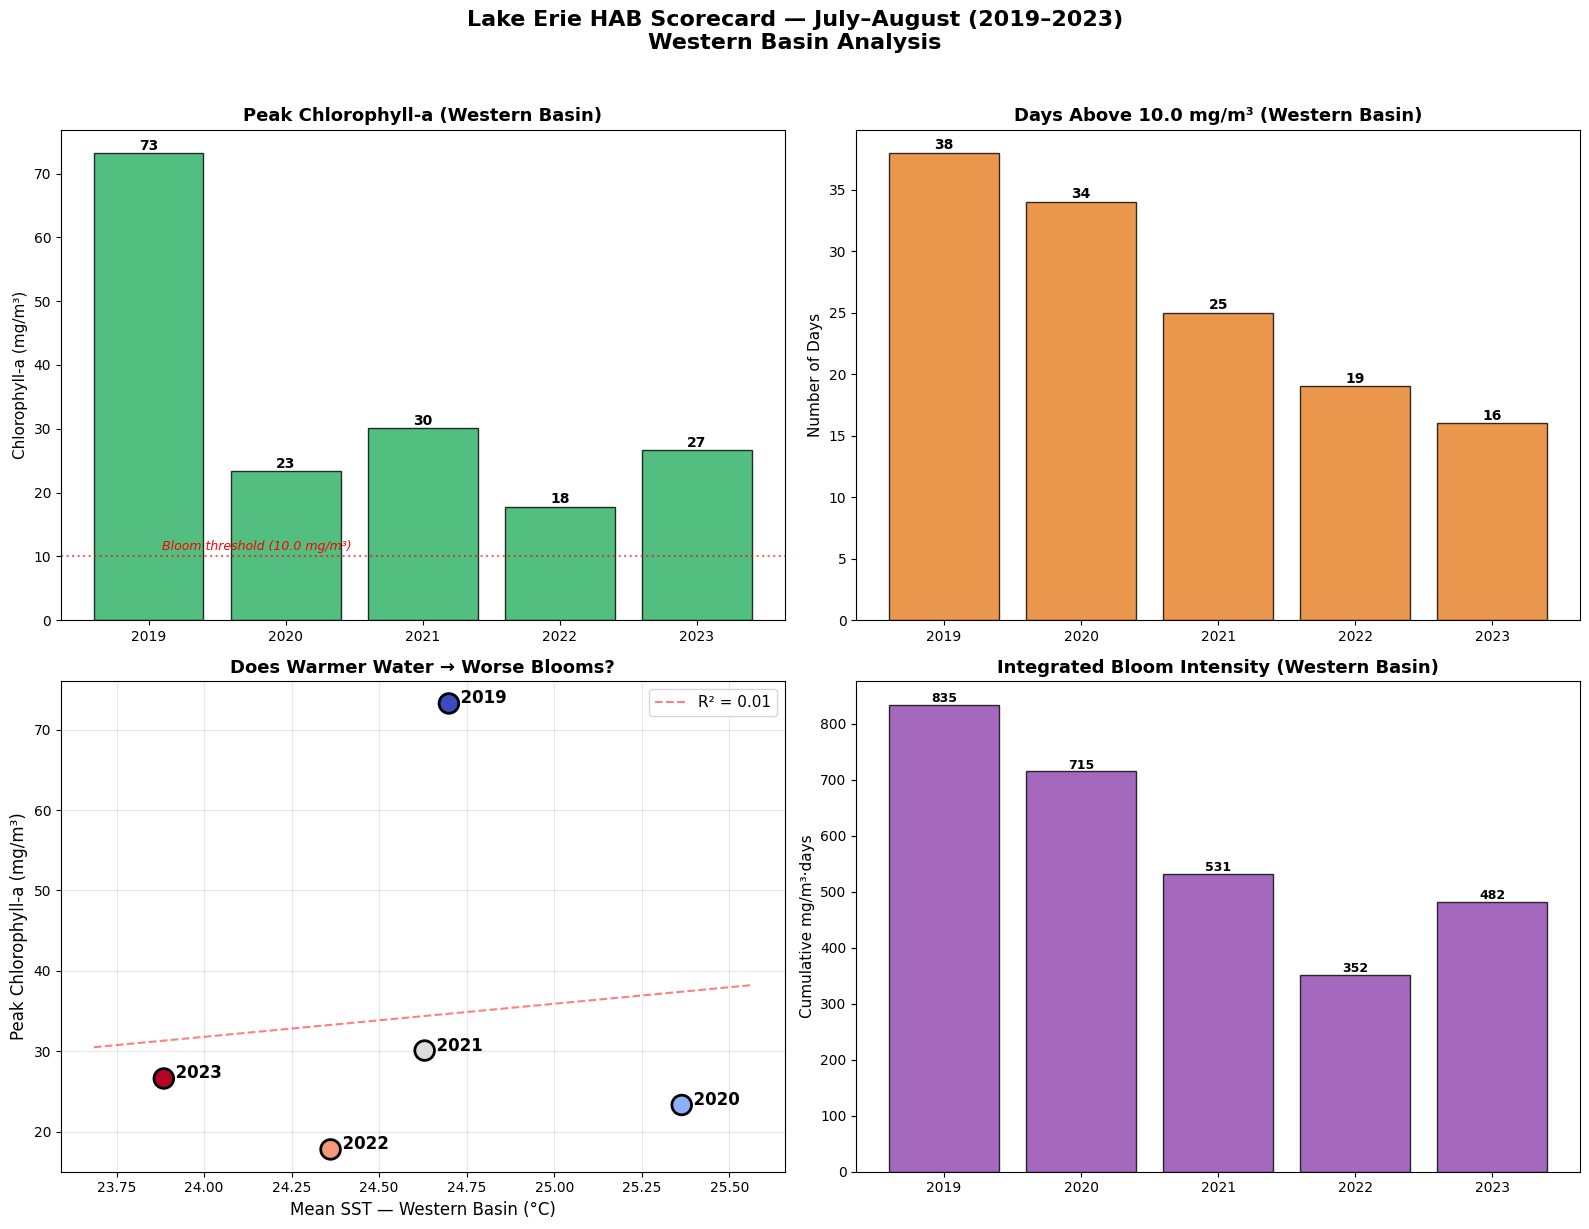

In [11]:
# ============================================================
# Multi-Year HAB Scorecard Visualization
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

years_plot = scorecard_df['year'].astype(int)
x = np.arange(len(years_plot))
bar_color = '#27AE60'
sst_color = '#C0392B'

# Top-left: Peak Chlorophyll by year
axes[0,0].bar(x, scorecard_df['peak_chl_west'], color=bar_color, alpha=0.8, edgecolor='black')
axes[0,0].set_title('Peak Chlorophyll-a (Western Basin)', fontsize=13, fontweight='bold')
axes[0,0].set_ylabel('Chlorophyll-a (mg/m³)', fontsize=11)
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(years_plot)
axes[0,0].axhline(y=BLOOM_THRESHOLD, color='red', linestyle=':', alpha=0.6)
axes[0,0].text(0.1, BLOOM_THRESHOLD + 1, f'Bloom threshold ({BLOOM_THRESHOLD} mg/m³)', 
               fontsize=9, color='red', style='italic')
for i, v in enumerate(scorecard_df['peak_chl_west']):
    axes[0,0].text(i, v + 0.5, f'{v:.0f}', ha='center', fontsize=10, fontweight='bold')

# Top-right: Bloom days by year
axes[0,1].bar(x, scorecard_df['bloom_days'], color='#E67E22', alpha=0.8, edgecolor='black')
axes[0,1].set_title(f'Days Above {BLOOM_THRESHOLD} mg/m³ (Western Basin)', fontsize=13, fontweight='bold')
axes[0,1].set_ylabel('Number of Days', fontsize=11)
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(years_plot)
for i, v in enumerate(scorecard_df['bloom_days']):
    axes[0,1].text(i, v + 0.3, f'{int(v)}', ha='center', fontsize=10, fontweight='bold')

# Bottom-left: SST vs Chlorophyll scatter (one point per year)
ax_bl = axes[1,0]
sc = ax_bl.scatter(scorecard_df['mean_sst_west'], scorecard_df['peak_chl_west'],
                   c=years_plot, cmap='coolwarm', s=200, edgecolors='black', linewidth=2, zorder=5)
for _, row in scorecard_df.iterrows():
    ax_bl.annotate(f"  {int(row['year'])}", 
                   (row['mean_sst_west'], row['peak_chl_west']),
                   fontsize=12, fontweight='bold')

# Regression
if len(scorecard_df) >= 3:
    slope, intercept, r_val, p_val, _ = stats.linregress(
        scorecard_df['mean_sst_west'], scorecard_df['peak_chl_west'])
    x_fit = np.linspace(scorecard_df['mean_sst_west'].min()-0.2, scorecard_df['mean_sst_west'].max()+0.2, 50)
    ax_bl.plot(x_fit, slope * x_fit + intercept, 'r--', alpha=0.5, 
               label=f'R² = {r_val**2:.2f}')
    ax_bl.legend(fontsize=11)

ax_bl.set_xlabel('Mean SST — Western Basin (°C)', fontsize=12)
ax_bl.set_ylabel('Peak Chlorophyll-a (mg/m³)', fontsize=12)
ax_bl.set_title('Does Warmer Water → Worse Blooms?', fontsize=13, fontweight='bold')
ax_bl.grid(True, alpha=0.3)

# Bottom-right: Integrated intensity trend
axes[1,1].bar(x, scorecard_df['integrated_intensity'], color='#8E44AD', alpha=0.8, edgecolor='black')
axes[1,1].set_title('Integrated Bloom Intensity (Western Basin)', fontsize=13, fontweight='bold')
axes[1,1].set_ylabel('Cumulative mg/m³·days', fontsize=11)
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(years_plot)
for i, v in enumerate(scorecard_df['integrated_intensity']):
    axes[1,1].text(i, v + 5, f'{v:.0f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Lake Erie HAB Scorecard — July–August (2019–2023)\nWestern Basin Analysis',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('output/hab_multiyear_scorecard.png', dpi=150, bbox_inches='tight')
plt.show()


## Step 6: Bloom Spatial Evolution — Monthly Composites

Where exactly do blooms develop, and how do they spread through the summer? By creating monthly chlorophyll composites (averaged over all valid observations per month), we can map the spatial progression of the bloom from June through September.

This reveals whether blooms stay confined to the western basin or spread eastward as the summer progresses — a key question for water treatment facilities along the lake's southern shore.


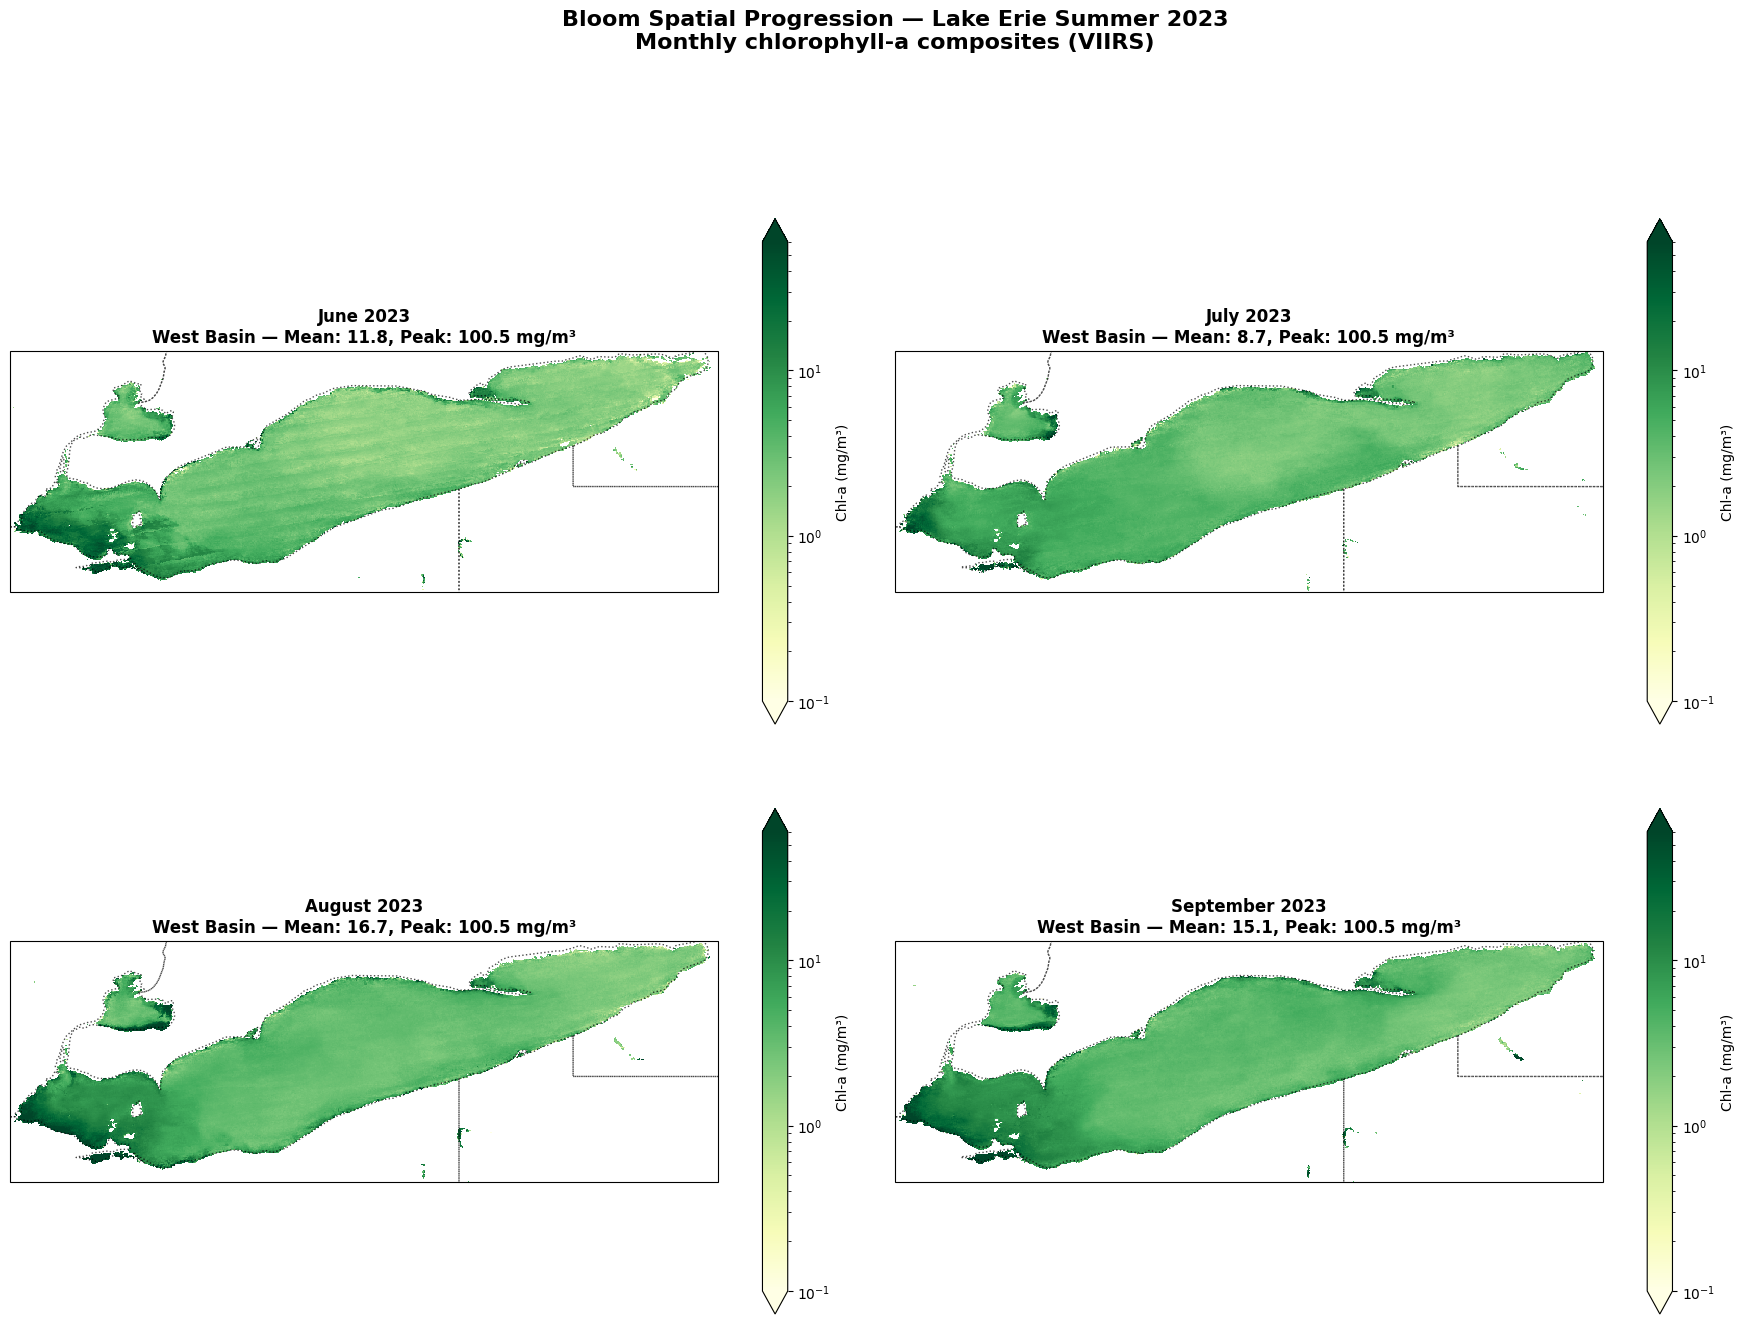

In [12]:
# ============================================================
# Monthly chlorophyll composites — spatial bloom progression
# ============================================================
months_plot = [
    ('June', ds_chl.Chlorophyll.sel(time=ds_chl.time.dt.month == 6)),
    ('July', ds_chl.Chlorophyll.sel(time=ds_chl.time.dt.month == 7)),
    ('August', ds_chl.Chlorophyll.sel(time=ds_chl.time.dt.month == 8)),
    ('September', ds_chl.Chlorophyll.sel(time=ds_chl.time.dt.month == 9)),
]

fig, axes = plt.subplots(2, 2, figsize=(18, 14),
                          subplot_kw={'projection': ccrs.PlateCarree()})

for ax, (month_name, data) in zip(axes.flat, months_plot):
    monthly_mean = data.mean(dim='time')
    
    monthly_mean.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=mcolors.LogNorm(vmin=0.1, vmax=60),
        cmap='YlGn',
        cbar_kwargs={'label': 'Chl-a (mg/m³)', 'shrink': 0.7}
    )
    
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
    ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.7)
    ax.set_extent([-83.5, -78.8, 41.3, 42.9])
    
    # Compute stats for title
    west_vals = monthly_mean.where(monthly_mean.longitude < WEST_BASIN_LON)
    mean_val = float(west_vals.mean())
    peak_val = float(west_vals.max())
    
    ax.set_title(f'{month_name} 2023\n'
                 f'West Basin — Mean: {mean_val:.1f}, Peak: {peak_val:.1f} mg/m³',
                 fontsize=12, fontweight='bold')

fig.suptitle('Bloom Spatial Progression — Lake Erie Summer 2023\n'
             'Monthly chlorophyll-a composites (VIIRS)',
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('output/hab_monthly_progression.png', dpi=150, bbox_inches='tight')
plt.show()


---

## Summary & Key Findings

### The Central Question: Does Temperature Drive Algal Blooms?

**The short answer: temperature is a necessary condition, but not a sufficient one.** This analysis demonstrates that while warm SST and high chlorophyll overlap spatially (Notebook 01), the temporal relationship is far weaker than simple models would predict. The primary control on bloom severity in Lake Erie is nutrient availability — dissolved phosphorus from the Maumee River — not temperature.

### Finding 1: No Same-Day Correlation (r = –0.19, p = 0.06)

Daily western-basin SST and chlorophyll-a show no statistically significant correlation. The slight *negative* association likely reflects physical processes: the hottest, most stratified days can suppress bloom activity by trapping nutrients below the surface layer where algae photosynthesize. SST explains only **2.2% of daily chlorophyll variance** (R² = 0.022).

### Finding 2: The Lag Signal Is Seasonal, Not Causal

Cross-correlation peaks at r = 0.47 with a 30-day lag — but this value climbs monotonically to the edge of our ±30-day search window without a clear peak. This pattern is consistent with a **seasonal offset** (SST peaks in late July; chlorophyll peaks in August–September) rather than a true causal lag. Distinguishing these would require detrending both time series to remove the seasonal signal before correlating residuals.

### Finding 3: The Warmest Year Was Not the Worst Bloom Year

The multi-year scorecard provides the strongest evidence that temperature alone doesn't control blooms:

| Year | Mean SST (West) | Peak Chlorophyll | Bloom Days (>10 mg/m³) | Integrated Intensity |
|------|-----------------|-----------------|----------------------|---------------------|
| **2019** | 24.7°C | **73 mg/m³** | **38** | **835** |
| **2020** | **25.4°C** | 23 mg/m³ | 34 | 715 |
| 2021 | 24.6°C | 30 mg/m³ | 25 | 531 |
| 2022 | 24.4°C | 18 mg/m³ | 19 | 352 |
| 2023 | 23.9°C | 27 mg/m³ | 16 | 482 |

2020 was **the warmest summer** (25.4°C) but produced only moderate blooms. 2019 was cooler but had the **worst bloom** by every metric — 73 mg/m³ peak, 38 bloom days, highest integrated intensity. The year-over-year R² between mean SST and peak chlorophyll is 0.01 — essentially zero. This confirms the scientific consensus: nutrient loading (especially spring/summer discharge from the Maumee River) is the primary driver.

### Finding 4: Blooms Are Spatially Persistent in the Western Basin

Monthly chlorophyll composites show elevated concentrations in the western basin from June through September, with the spatial footprint expanding slightly through the season. The eastern basin remains consistently low (< 3 mg/m³), confirming that the bloom is geographically anchored to the nutrient input zone near Toledo and the Bass Islands.

### Finding 5: VIIRS Data Is Sparse but Usable

Cloud cover limits individual VIIRS overpasses to ~10% spatial coverage on average. However, daily compositing (averaging all overpasses per day) recovers 99 of 118 summer days with valid lake-wide means. This demonstrates that multi-overpass compositing is essential for any chlorophyll time-series analysis in the Great Lakes region.

### What This Means

For environmental monitoring, these results suggest:
- **SST alone is insufficient** as a bloom early-warning indicator
- A useful predictive model would need to incorporate **Maumee River discharge data** (nutrient proxy) alongside SST
- The **western basin** should be the focus of any monitoring system — the eastern basin is not at risk
- **2019 warrants deeper investigation** — what made its nutrient conditions so bloom-favorable?

---

*Project Blue Nexus — Ryan Jones, February 2026*
